In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras import initializers
from keras.layers import Dense, Dropout, Input ,BatchNormalization
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam
from tensorflow.test import is_gpu_available
print (is_gpu_available())

Using TensorFlow backend.


True


In [2]:
def visulaize(X_train,y_train):
    fig = plt.figure()
    for i in range(10):
        plt.subplot(2, 5, i+1)
        x_y = X_train[y_train == i]
        plt.imshow(x_y[0], cmap='gray', interpolation='none')
        plt.title("Class %d" % (i))
        plt.xticks([])
        plt.yticks([])
    
    plt.tight_layout()


def load_data(verbose=False):
    # load dataset
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    if verbose:
        visulaize(X_train,y_train)
    # Reshaping and normalizing the inputs
    print('X_train.shape', X_train.shape)

    # reshaping the inputs
    X_train = X_train.reshape(60000, 28*28)
    # normalizing the inputs (-1, 1)
    X_train = (X_train.astype('float32') / 255 - 0.5) * 2

    print('X_train reshape:', X_train.shape)
    
    return X_train, y_train, X_test, y_test

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 784)


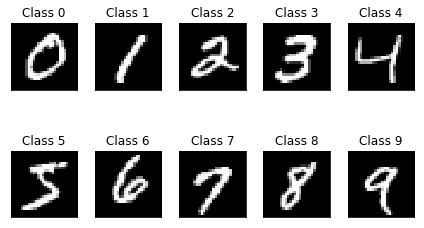

In [3]:
xtrain,ytrain,xtest,ytest = load_data(verbose=True)
# for i in range(10):
#     plt.subplot(2, 5, i+1)
#     x_y = xtrain[i]
#     img = x_y.reshape(28,28)
#     plt.imshow(img,cmap='gray')
#     plt.title("Class %d" % (i))
#     plt.xticks([])
#     plt.yticks([])

#     plt.show()

# plt.tight_layout()

We will use Adam optimizer as it is computationally efficient and has very little memory requirement. Adam is a combination of Adagrad and RMSprop.

In [4]:
def adam_optimizer():
    return adam(lr=0.0002, beta_1=0.5)

We create Generator which uses MLP using simple dense layers activated by tanh

In [5]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

def create_generator():
    # Generator network
    generator = Sequential()

    # Input layer and hidden layer 1
    generator.add(Dense(128, input_shape=(latent_dim,), kernel_initializer=init))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization(momentum=0.8))

    # Hidden layer 2
    generator.add(Dense(256))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization(momentum=0.8))

    # Hidden layer 3
    generator.add(Dense(512))
    generator.add(LeakyReLU(alpha=0.2))
    generator.add(BatchNormalization(momentum=0.8))

    # Output layer 
    generator.add(Dense(img_dim, activation='tanh'))
    return generator

g=create_generator()
g.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dens

We now create the Discriminator which is also MLP. Discriminator will take the input from real data which is of the size 784 and also the images generated from Generator.

In [6]:
# pass image size or the last layer output 
def create_discriminator():
    # Discriminator network
    discriminator = Sequential()

    # Input layer and hidden layer 1
    discriminator.add(Dense(128, input_shape=(img_dim,), kernel_initializer=init))
    discriminator.add(LeakyReLU(alpha=0.2))

    # Hidden layer 2
    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(alpha=0.2))

    # Hidden layer 3
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(alpha=0.2))
    
    # Hidden layer 4
    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(alpha=0.2))
    
    # Add Dropout 
    discriminator.add(Dropout(0.5))
    # Output layer
    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer(),metrics=['accuracy'])
    return discriminator

d =create_discriminator()
d.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               100480    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
___________________________

In [7]:
 ## we combine the Generator and Discriminator. 
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,)) # keras input
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
    return gan

def plot_loss(losses):
    """
    losses.keys():
        0: loss
        1: accuracy
    """
    print ("loss = ",losses["D"])
    d_loss = [v for v in losses["D"]]
    g_loss = [v for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [8]:
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               583312    
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 528257    
Total params: 1,111,569
Trainable params: 581,520
Non-trainable params: 530,049
_________________________________________________________________


In [9]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [10]:
# Set up a vector (dict) to store the losses
losses = {"D":[], "G":[]}

epochs = 100
batch_size = 128
smooth = 0.1

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))


generator= create_generator()
discriminator= create_discriminator()
d_g = create_gan(discriminator, generator)

d_loss = []
d_g_loss = []

def training(epochs=100, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    for e in range(epochs + 1):
        for i in range(len(X_train) // batch_size):
            # Train Discriminator weights
            discriminator.trainable = True
            # Real samples
            X_batch = X_train[i*batch_size:(i+1)*batch_size]
            d_loss_real = discriminator.train_on_batch(x=X_batch, y=real * (1 - smooth))
    
            # Fake Samples
            z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
            X_fake = generator.predict_on_batch(z)
            d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
            
            # Discriminator loss
            d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
            
            # Train Generator weights
            discriminator.trainable = False
            d_g_loss_batch = d_g.train_on_batch(x=z, y=real)
            
            print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, d_g_loss_batch[0]),
            100*' ',
            end='\r'
        )
            
        d_loss.append(d_loss_batch)
        d_g_loss.append(d_g_loss_batch[0])
        print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], d_g_loss[-1]), 100*' ')

        if e % 10 == 0:
            samples = 10
            x_fake = generator.predict(np.random.normal(loc=0, scale=1, size=(samples, latent_dim)))

            for k in range(samples):
                plt.subplot(2, 5, k+1)
                plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
                plt.xticks([])
                plt.yticks([])

            plt.tight_layout()
            plt.show()
            
    return d_loss,d_g_loss
    


X_train.shape (60000, 28, 28)
X_train reshape: (60000, 784)
Instructions for updating:
Use tf.cast instead.
epoch = 1/80, d_loss=0.229, g_loss=5.834                                                                                                                       


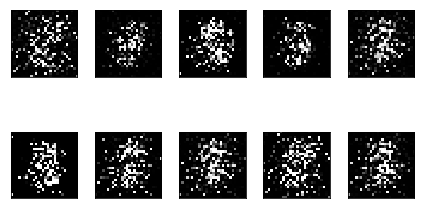

epoch = 2/80, d_loss=0.210, g_loss=5.926                                                                                                                       
epoch = 3/80, d_loss=0.186, g_loss=8.728                                                                                                                       
epoch = 4/80, d_loss=0.233, g_loss=7.007                                                                                                                       
epoch = 5/80, d_loss=0.227, g_loss=8.824                                                                                                                       
epoch = 6/80, d_loss=0.285, g_loss=5.868                                                                                                                       
epoch = 7/80, d_loss=0.335, g_loss=4.713                                                                                                                      
epoch = 8/80, d_loss=0.247, g_loss=3.491 

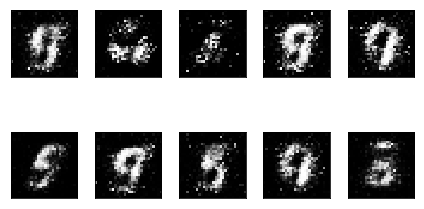

epoch = 12/80, d_loss=0.394, g_loss=3.203                                                                                                                      
epoch = 13/80, d_loss=0.387, g_loss=3.047                                                                                                                      
epoch = 14/80, d_loss=0.341, g_loss=2.917                                                                                                                      
epoch = 15/80, d_loss=0.338, g_loss=3.282                                                                                                                      
epoch = 16/80, d_loss=0.389, g_loss=2.849                                                                                                                      
epoch = 17/80, d_loss=0.475, g_loss=2.231                                                                                                                      
epoch = 18/80, d_loss=0.388, g_loss=3.10

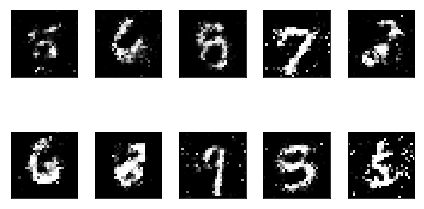

epoch = 22/80, d_loss=0.632, g_loss=1.937                                                                                                                      
epoch = 23/80, d_loss=0.508, g_loss=2.182                                                                                                                      
epoch = 24/80, d_loss=0.516, g_loss=1.852                                                                                                                      
epoch = 25/80, d_loss=0.568, g_loss=1.895                                                                                                                      
epoch = 26/80, d_loss=0.564, g_loss=1.930                                                                                                                      
epoch = 27/80, d_loss=0.540, g_loss=1.884                                                                                                                      
epoch = 28/80, d_loss=0.498, g_loss=2.16

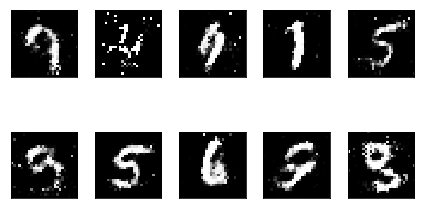

epoch = 32/80, d_loss=0.562, g_loss=1.891                                                                                                                      
epoch = 33/80, d_loss=0.518, g_loss=1.973                                                                                                                      
epoch = 34/80, d_loss=0.581, g_loss=2.025                                                                                                                      
epoch = 35/80, d_loss=0.513, g_loss=2.005                                                                                                                      
epoch = 36/80, d_loss=0.579, g_loss=1.773                                                                                                                      
epoch = 37/80, d_loss=0.559, g_loss=1.835                                                                                                                      
epoch = 38/80, d_loss=0.552, g_loss=1.81

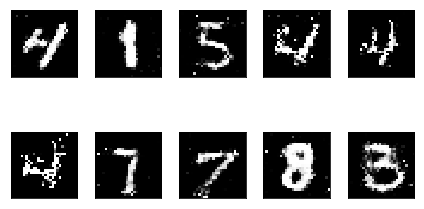

epoch = 42/80, d_loss=0.560, g_loss=1.902                                                                                                                      
epoch = 43/80, d_loss=0.599, g_loss=1.762                                                                                                                      
epoch = 44/80, d_loss=0.563, g_loss=1.890                                                                                                                      
epoch = 45/80, d_loss=0.533, g_loss=1.708                                                                                                                      
epoch = 46/80, d_loss=0.543, g_loss=1.909                                                                                                                      
epoch = 47/80, d_loss=0.580, g_loss=1.825                                                                                                                      
epoch = 48/80, d_loss=0.555, g_loss=1.91

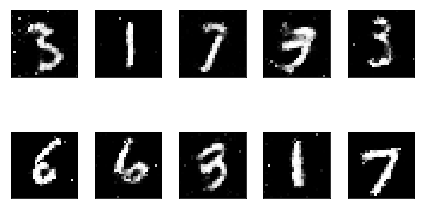

epoch = 52/80, d_loss=0.582, g_loss=1.816                                                                                                                      
epoch = 53/80, d_loss=0.561, g_loss=1.750                                                                                                                      
epoch = 54/80, d_loss=0.589, g_loss=1.893                                                                                                                      
epoch = 55/80, d_loss=0.560, g_loss=1.955                                                                                                                      
epoch = 56/80, d_loss=0.551, g_loss=1.965                                                                                                                      
epoch = 57/80, d_loss=0.565, g_loss=2.095                                                                                                                      
epoch = 58/80, d_loss=0.548, g_loss=2.03

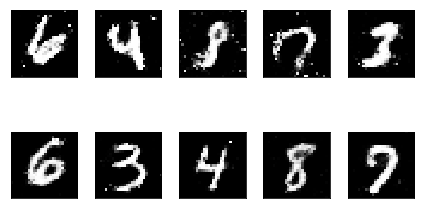

epoch = 62/80, d_loss=0.548, g_loss=1.999                                                                                                                      
epoch = 63/80, d_loss=0.544, g_loss=1.764                                                                                                                      
epoch = 64/80, d_loss=0.595, g_loss=1.821                                                                                                                      
epoch = 65/80, d_loss=0.645, g_loss=1.706                                                                                                                      
epoch = 66/80, d_loss=0.548, g_loss=2.138                                                                                                                      
epoch = 67/80, d_loss=0.567, g_loss=1.974                                                                                                                      
epoch = 68/80, d_loss=0.537, g_loss=1.88

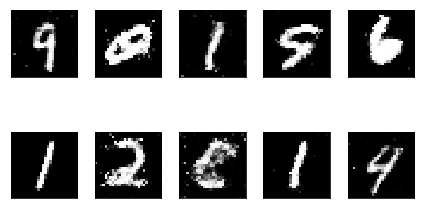

epoch = 72/80, d_loss=0.604, g_loss=1.805                                                                                                                      
epoch = 73/80, d_loss=0.559, g_loss=1.838                                                                                                                      
epoch = 74/80, d_loss=0.573, g_loss=2.012                                                                                                                      
epoch = 75/80, d_loss=0.568, g_loss=1.889                                                                                                                      
epoch = 76/80, d_loss=0.595, g_loss=1.824                                                                                                                      
epoch = 77/80, d_loss=0.605, g_loss=1.919                                                                                                                      
epoch = 78/80, d_loss=0.624, g_loss=1.74

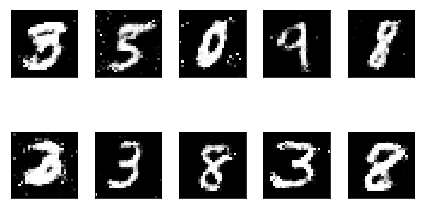

loss =  [0.22852718830108643, 0.20967327058315277, 0.1855241358280182, 0.23326897621154785, 0.2271401435136795, 0.2850872278213501, 0.3349735736846924, 0.24733997881412506, 0.28801774978637695, 0.3700815439224243, 0.35678574442863464, 0.39429065585136414, 0.3866525888442993, 0.34095698595046997, 0.3381618857383728, 0.38868647813796997, 0.4752041697502136, 0.3883494436740875, 0.4228193759918213, 0.41742730140686035, 0.5094372034072876, 0.6318208575248718, 0.5076896548271179, 0.5163760781288147, 0.5684945583343506, 0.5638030171394348, 0.5399607419967651, 0.4982864260673523, 0.5717136859893799, 0.5488919615745544, 0.5690770149230957, 0.5615283846855164, 0.5177133083343506, 0.5805230736732483, 0.5130318403244019, 0.5786464214324951, 0.5590729713439941, 0.5524249076843262, 0.5497421026229858, 0.5575039982795715, 0.599643349647522, 0.5602365732192993, 0.5989159345626831, 0.5631003975868225, 0.5332474708557129, 0.5426443219184875, 0.5801897048950195, 0.5554273128509521, 0.5223508477210999, 0.

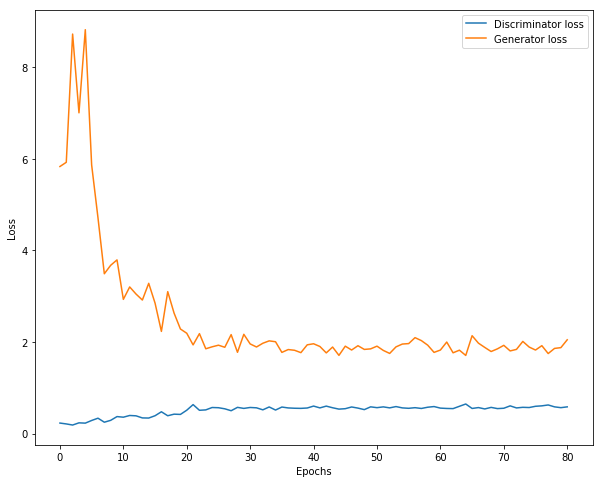

In [11]:
d_loss,d_g_loss = training(80,128)
losses['D'] = d_loss
losses['G'] = d_g_loss
plot_loss(losses)